In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="DLZRWqPmPgXpy0mevy0T")
project = rf.workspace("hundairotemtraining").project("image-detection-dxhgd")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Image-Detection-2 in yolov8:: 100%|██████████| 32/32 [00:00<00:00, 6068.53it/s]


### 오른쪽에 붙이기

🖼 이미지 저장 완료 (바운딩 박스 없음): ./syn/syn_img/combined.jpg
✅ 라벨 저장 완료: ./syn/syn_label/combined.txt


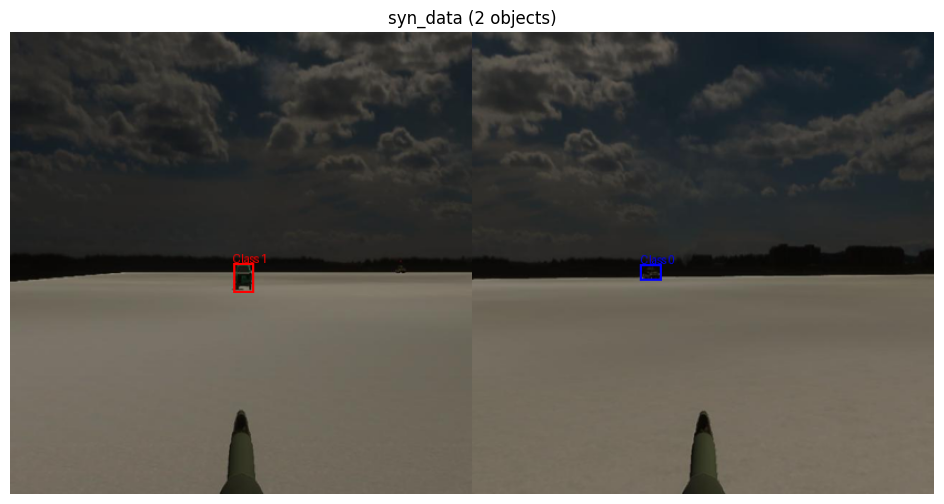

In [47]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# 📂 파일 경로 설정
img1_path = './Image-Detection-2/train/images/capture_0000_png.rf.50333dc182c003bae1683484a09902ad.jpg'
img2_path = './Image-Detection-2/train/images/capture_0016_png.rf.6a17b5cd49216511b745314d21f21e35.jpg'
label1_path = './Image-Detection-2/train/labels/capture_0000_png.rf.50333dc182c003bae1683484a09902ad.txt'
label2_path = './Image-Detection-2/train/labels/capture_0016_png.rf.6a17b5cd49216511b745314d21f21e35.txt'

# 📁 저장 폴더 경로
save_dir_img = './syn/syn_img/'
save_dir_label = './syn/syn_label/'
os.makedirs(save_dir_img, exist_ok=True)
os.makedirs(save_dir_label, exist_ok=True)

# 저장 파일 이름
save_img_path = os.path.join(save_dir_img, 'combined.jpg')
save_label_path = os.path.join(save_dir_label, 'combined.txt')

# YOLO 형식 라벨 읽기
def read_yolo_label(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [list(map(float, line.strip().split())) for line in lines]

# YOLO 상대좌표를 절대 좌표로 변환
def yolo_to_box(x, y, w, h, img_width, img_height):
    x_center = x * img_width
    y_center = y * img_height
    box_w = w * img_width
    box_h = h * img_height
    x_min = x_center - box_w / 2
    y_min = y_center - box_h / 2
    x_max = x_center + box_w / 2
    y_max = y_center + box_h / 2
    return [x_min, y_min, x_max, y_max]

# 절대좌표를 YOLO 좌표로 변환
def box_to_yolo(x_min, y_min, x_max, y_max, img_width, img_height):
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    box_w = (x_max - x_min) / img_width
    box_h = (y_max - y_min) / img_height
    return [x_center, y_center, box_w, box_h]

# 이미지 불러오기 & 크기 맞추기
img1 = Image.open(img1_path).resize((416, 416))
img2 = Image.open(img2_path).resize((416, 416))

# 좌우 합성
combined_img = Image.new("RGB", (832, 416))
combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (416, 0))

# 🎯 바운딩 박스 없이 저장할 복사본 만들기
combined_clean = combined_img.copy()  # 이 이미지를 저장
draw = ImageDraw.Draw(combined_img)   # 시각화 용도로만 사용

# 라벨 불러오기
labels1 = read_yolo_label(label1_path)
labels2 = read_yolo_label(label2_path)

# 바운딩 박스 그리기
draw = ImageDraw.Draw(combined_img)

# 라벨 저장용 리스트
new_yolo_labels = []

# img1의 바운딩 박스 (좌측)
for cls, x, y, w, h in labels1:
    # 원래 이미지의 좌측 416x416 -> 좌우합성 이미지에서 왼쪽 절반 (그대로)
    box = yolo_to_box(x * 0.5, y, w * 0.5, h, 832, 416)
    draw.rectangle(box, outline="red", width=2)
    draw.text((box[0], box[1]-10), f"Class {int(cls)}", fill="red")

    # YOLO 좌표로 다시 변환하여 저장
    yolo_box = box_to_yolo(*box, 832, 416)
    new_yolo_labels.append([int(cls)] + yolo_box)

# img2의 바운딩 박스 (우측)
for cls, x, y, w, h in labels2:
    # x 위치 조정: 오른쪽으로 416픽셀만큼 이동
    new_x = 0.5 + x * 0.5
    box = yolo_to_box(new_x, y, w * 0.5, h, 832, 416)
    draw.rectangle(box, outline="blue", width=2)
    draw.text((box[0], box[1]-10), f"Class {int(cls)}", fill="blue")

    # YOLO 좌표로 다시 변환하여 저장
    yolo_box = box_to_yolo(*box, 832, 416)
    new_yolo_labels.append([int(cls)] + yolo_box)

# 이미지 저장
combined_clean.save(save_img_path)
print(f"🖼 이미지 저장 완료 (바운딩 박스 없음): {save_img_path}")

# 📝 YOLO 라벨 저장
with open(save_label_path, 'w') as f:
    for label in new_yolo_labels:
        line = ' '.join([str(label[0])] + [f"{v:.6f}" for v in label[1:]])
        f.write(line + '\n')

print(f"✅ 라벨 저장 완료: {save_label_path}")

# 결과 이미지 보기
plt.figure(figsize=(12, 6))
plt.imshow(combined_img)
plt.axis('off')
plt.title("syn_data (2 objects)")
plt.show()


## ✅ 선택 배경
YOLO 라벨 기반 객체 crop + 배경 제거 + 합성 이미지 저장 전체 코드

### 합성 이미지 라벨링

1. 기존 YOLO 라벨 파일 읽기: 각 객체 이미지에 대한 YOLO 라벨 파일을 읽어들입니다.​

2. 합성 이미지의 크기 파악: 합성된 이미지의 크기를 확인합니다. 이는 각 객체의 바운딩 박스를 합성 이미지에 맞게 변환하기 위해 필요합니다.​

3. 객체의 바운딩 박스 위치 조정: 각 객체의 바운딩 박스를 합성 이미지 내에서의 위치에 맞게 조정합니다. 예를 들어, 두 번째 객체는 첫 번째 객체의 오른쪽에 배치되었다면, 두 번째 객체의 바운딩 박스의 x 좌표를 첫 번째 객체의 x 좌표와 첫 번째 객체의 너비를 더한 값으로 조정합니다.​

4. YOLO 라벨 파일 생성: 조정된 바운딩 박스 정보를 바탕으로 새로운 YOLO 라벨 파일을 생성합니다. 이때, 각 객체의 클래스 ID는 기존 라벨 파일에서 가져옵니다.

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image
import os
import random

def parse_yolo_labels(img, label_path):
    h, w = img.shape[:2]
    crops = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            x_center *= w
            y_center *= h
            box_w *= w
            box_h *= h
            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(x2, w), min(y2, h)
            crop = img[y1:y2, x1:x2]
            crops.append((crop, int(cls)))
    return crops

def remove_bg(cv2_img):
    pil_img = Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
    no_bg_pil = remove(pil_img)
    no_bg_cv2 = cv2.cvtColor(np.array(no_bg_pil), cv2.COLOR_RGBA2BGRA)
    return no_bg_cv2

def random_scale(image, scale_min=0.5, scale_max=1.5):
    scale_factor = random.uniform(scale_min, scale_max)
    new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
    return cv2.resize(image, new_size)

def random_rotate(image):
    angle = random.randint(0, 360)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, mat, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    return rotated

def paste_transparent(background, overlay, x, y):
    bh, bw = background.shape[:2]
    oh, ow = overlay.shape[:2]
    if y + oh > bh: oh = bh - y
    if x + ow > bw: ow = bw - x
    overlay = overlay[:oh, :ow]
    alpha_overlay = overlay[:, :, 3] / 255.0
    alpha_bg = 1.0 - alpha_overlay
    for c in range(3):
        background[y:y+oh, x:x+ow, c] = (
            alpha_overlay * overlay[:, :, c] + alpha_bg * background[y:y+oh, x:x+ow, c]
        )
    return background, (x, y, x + ow, y + oh)

def convert_to_yolo_bbox(x1, y1, x2, y2, img_w, img_h):
    cx = (x1 + x2) / 2 / img_w
    cy = (y1 + y2) / 2 / img_h
    w = (x2 - x1) / img_w
    h = (y2 - y1) / img_h
    return cx, cy, w, h

def compose_multi_object_images(
    image_paths,
    label_paths,
    background_path=None,
    save_img_path="./syn/syn_img/syn.png",
    save_label_path="./syn/syn_label/syn.txt",
    scale_min=0.5,
    scale_max=1.5,
    show_bbox=True
):
    assert len(image_paths) == len(label_paths), "이미지와 라벨 수가 일치해야 합니다."

    # 배경 이미지 설정
    if background_path and os.path.exists(background_path):
        bg = cv2.imread(background_path)
        bg = cv2.cvtColor(bg, cv2.COLOR_BGR2BGRA)
        print(f"🖼 사용자 배경 사용: {background_path}")
    else:
        bg = np.ones((600, 1000, 4), dtype=np.uint8) * 255
        print("🖼 기본 흰 배경 사용")

    composed = bg.copy()               # 저장용 (bbox 없음)
    composed_vis = composed.copy()     # 시각화용 (bbox 표시용)

    img_h, img_w = composed.shape[:2]
    current_x, current_y = 50, 50
    max_row_height = 0
    yolo_labels = []

    for img_path, label_path in zip(image_paths, label_paths):
        img = cv2.imread(img_path)
        crops = parse_yolo_labels(img, label_path)

        for crop_img, cls in crops:
            crop_img = random_scale(crop_img, scale_min, scale_max)
            crop_img = random_rotate(crop_img)
            no_bg = remove_bg(crop_img)
            h, w = no_bg.shape[:2]

            if current_x + w > img_w - 50:
                current_x = 50
                current_y += max_row_height + 20
                max_row_height = 0

            composed, (x1, y1, x2, y2) = paste_transparent(composed, no_bg, current_x, current_y)
            composed_vis, _ = paste_transparent(composed_vis, no_bg, current_x, current_y)

            # YOLO 라벨 저장용 bbox
            cx, cy, bw, bh = convert_to_yolo_bbox(x1, y1, x2, y2, img_w, img_h)
            yolo_labels.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

            # 시각화용 bbox만 그리기
            if show_bbox:
                cv2.rectangle(composed_vis, (x1, y1), (x2, y2), (0, 0, 255, 255), 2)

            current_x += w + 20
            max_row_height = max(max_row_height, h)

    # 저장
    os.makedirs(os.path.dirname(save_img_path), exist_ok=True)
    os.makedirs(os.path.dirname(save_label_path), exist_ok=True)
    cv2.imwrite(save_img_path, composed)  # 바운딩 박스 없는 이미지 저장
    with open(save_label_path, 'w') as f:
        f.write("\n".join(yolo_labels))

    print(f"✅ 이미지 저장 완료 (bbox 없음): {save_img_path}")
    print(f"✅ 라벨 저장 완료: {save_label_path}")

    # 시각화
    plt.imshow(cv2.cvtColor(composed_vis, cv2.COLOR_BGRA2RGBA))
    plt.axis('off')
    plt.title("Synthetic Image (with bbox)")
    plt.show()


🖼 사용자 배경 사용: ./etc_data/bg_img/dust.jpeg
✅ 이미지 저장 완료 (bbox 없음): ./syn/syn_img/syn_01.png
✅ 라벨 저장 완료: ./syn/syn_label/syn_01.txt


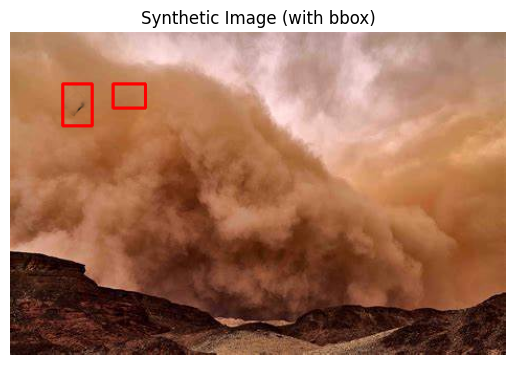

In [76]:
image_paths = ['./Image-Detection-2/train/images/capture_0000_png.rf.50333dc182c003bae1683484a09902ad.jpg'
,  './Image-Detection-2/train/images/capture_0016_png.rf.6a17b5cd49216511b745314d21f21e35.jpg']
label_paths = ['./Image-Detection-2/train/labels/capture_0000_png.rf.50333dc182c003bae1683484a09902ad.txt', './Image-Detection-2/train/labels/capture_0016_png.rf.6a17b5cd49216511b745314d21f21e35.txt'
]
bg_path = "./etc_data/bg_img/dust.jpeg"

compose_multi_object_images(
    image_paths,
    label_paths,
    background_path=bg_path,
    save_img_path="./syn/syn_img/syn_01.png",
    save_label_path="./syn/syn_label/syn_01.txt",
    scale_min=0.8,
    scale_max=1.2,
    show_bbox=True
)

사물인식 테스트

In [9]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

def detect_and_plot_yolov8(image_path, model_name='yolov8x.pt', conf=0.3):
    # 1. 모델 불러오기
    model = YOLO(model_name)

    # 2. 이미지 예측
    results = model(image_path, conf=conf)

    # 3. 바운딩 박스가 그려진 결과 이미지 얻기
    annotated_image = results[0].plot()

    # 4. 결과 이미지 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("YOLOv8 Detection Result")
    plt.show()

    # 5. 바운딩 박스 정보 출력
    boxes = results[0].boxes
    for i, box in enumerate(boxes):
        cls_id = int(box.cls[0])
        conf_score = float(box.conf[0])
        xyxy = box.xyxy[0].tolist()
        print(f"[{i}] Class: {model.names[cls_id]}, Confidence: {conf_score:.2f}, Box: {xyxy}")

    return results



image 1/1 /home/hara/workspace/python-docker/Aug_dev/syn_img/syn_test1_sand.png: 448x640 (no detections), 100.7ms
Speed: 1.9ms preprocess, 100.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


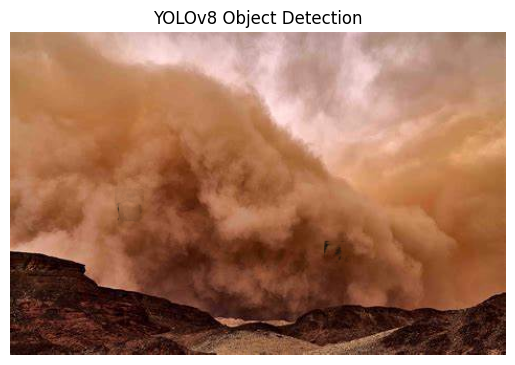

In [12]:
results = detect_objects_yolov8('./syn_img/syn_test1_sand.png')


image 1/1 /home/hara/workspace/python-docker/Aug_dev/syn_img/syn_test2_sand2.png: 448x640 1 chair, 84.9ms
Speed: 2.2ms preprocess, 84.9ms inference, 110.1ms postprocess per image at shape (1, 3, 448, 640)


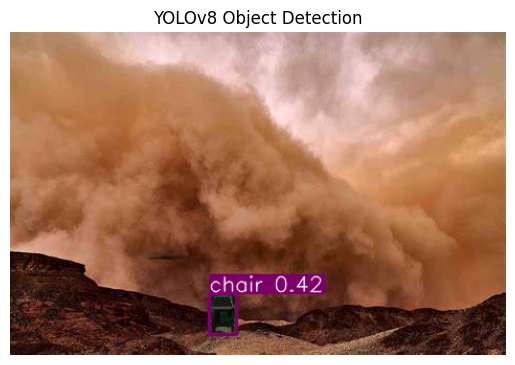

In [11]:
results = detect_objects_yolov8('./syn_img/syn_test2_sand2.png')


image 1/1 /home/hara/workspace/python-docker/Aug_dev/syn_img/syn_test5_snow.png: 448x640 1 car, 1 bench, 86.0ms
Speed: 2.1ms preprocess, 86.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


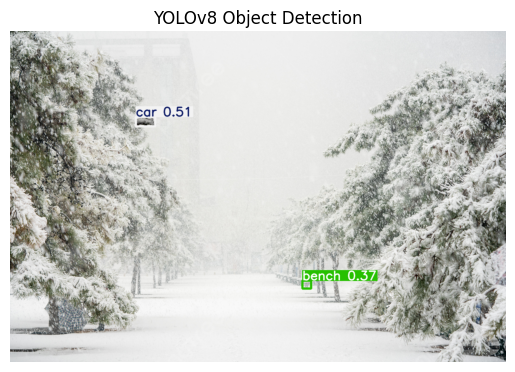

In [13]:
results = detect_objects_yolov8('./syn_img/syn_test5_snow.png')